In [52]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, GRU, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def get_file_paths(directory):
    # Function to get all file paths from a directory
    file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.png'))]
    return file_paths

def load_and_preprocess_data(image_paths, mask_paths, img_size=(128, 128), num_classes=5):
    # Function to load and preprocess a single image-mask pair
    def process_path(image_path, mask_path):
        # Load image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

        # Load mask
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.squeeze(mask, axis=-1)
        mask = tf.one_hot(tf.cast(mask, tf.int32), num_classes)  # One-hot encode the mask

        return image, mask

    # Create TensorFlow Dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

def build_grnn_segmentation_model(input_shape, num_classes):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Reshape for GRNN
    b, h, w, c = x.shape
    x = Reshape((h * w, c))(x)

    # GRNN Layer
    x = GRU(256, return_sequences=True)(x)
    x = Reshape((h, w, 256))(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Ensure it matches output size
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)

    # Adjust output size to match target shape (128x128)
    x = UpSampling2D((2, 2))(x)  # Final upsampling to (128, 128)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Output shape: (128, 128, num_classes)

    # Build Model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example directories (replace with your dataset's directory paths)
image_dirs = [r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\train_images"]
mask_dirs = [r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\train_masks"]

# Collect all image and mask file paths
image_paths = []
mask_paths = []
for image_dir, mask_dir in zip(image_dirs, mask_dirs):
    image_paths.extend(get_file_paths(image_dir))
    mask_paths.extend(get_file_paths(mask_dir))

# Hyperparameters
input_shape = (128, 128, 3)  # Input shape matches the resized images
num_classes = 5  # Number of segmentation classes
batch_size = 32
epochs = 20

# Load and preprocess the dataset
dataset = load_and_preprocess_data(image_paths, mask_paths, img_size=(128, 128), num_classes=num_classes)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the model
model = build_grnn_segmentation_model(input_shape, num_classes)

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

# Save the trained model
model.save('grnn_segmentation_model.h5')


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 128, 128, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_18 (Reshape)                 │ (None, 16384, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 16384, 256)          │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_19 (Reshape)                 │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 128, 128, 128)       │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_34 (UpSampling2D)      │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_30                  │ (None, 256, 256, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_35 (UpSampling2D)      │ (None, 512, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 512, 512, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 512, 512, 5)         │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153,029 (4.40 MB)

 Trainable params: 1,153,029 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 128, 128, 5), output.shape=(None, 512, 512, 5)

In [10]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, GRU, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array


In [11]:
img_height, img_width= 128, 128
batch_size = 16

In [12]:
def load_image_and_mask(image_path, mask_path, img_height, img_width):
    image = load_img(image_path, target_size=(img_height, img_width))
    mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
    
    image = img_to_array(image) / 255.0  # Normalize image
    mask = img_to_array(mask) / 255.0    # Normalize mask

    return image, mask

In [16]:
def custom_data_generator(image_folder, mask_folder, batch_size, img_height, img_width):
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)

    while True:
        for i in range(0, len(image_files), batch_size):
            batch_images = []
            batch_masks = []

            for j in range(i, min(i + batch_size, len(image_files))):
                image_path = os.path.join(image_folder, image_files[j])
                mask_path = os.path.join(mask_folder, mask_files[j])

                image, mask = load_image_and_mask(image_path, mask_path, img_height, img_width)
                batch_images.append(image)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)


In [18]:
image_folder = r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\train_images"
mask_folder = r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\train_masks"

img_height, img_width = 128, 128  
batch_size = 32 

train_generator = custom_data_generator(image_folder, mask_folder, batch_size, img_height, img_width)

images, masks = next(train_generator)
print(f"Batch of images shape: {images.shape}, Batch of masks shape: {masks.shape}")

NameError: name 'os' is not defined

In [15]:
input_img = Input(shape=(img_height, img_width, 3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Reshape((img_height // 2 * img_width // 2, 128))(x)  # Flatten to a sequence
x = GRU(64, return_sequences=True)(x)  # GRU layer
x = Reshape((img_height // 2, img_width // 2, 64))(x)  # Reshape back
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
output = Conv2D(1, (1, 1), activation='sigmoid')(x)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model.fit(train_generator, steps_per_epoch=len(os.listdir(image_folder)) // batch_size, epochs=10)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.6325 - loss: 0.5840
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6931 - loss: 0.5245
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7062 - loss: 0.5031
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6965 - loss: 0.5003
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.7143 - loss: 0.4797
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.7126 - loss: 0.4768
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.7187 - loss: 0.4600
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.7026 - loss: 0.4727
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7319 - loss: 0.4537
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.7281 - loss: 0.4522


In [67]:
model.save("GRU_segmentation_model.keras")

In [78]:
from sklearn.metrics import accuracy_score
def load_and_preprocess_image(image_path, img_height, img_width):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image) / 255.0  
    return np.expand_dims(image, axis=0) 

new_image_path = r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\valid_images\water_body_8680.jpg"
new_image = load_and_preprocess_image(new_image_path, img_height, img_width)

predicted_mask = model.predict(new_image)
predicted_mask = (predicted_mask.squeeze() > 0.5).astype(np.uint8)  
accuracy = accuracy_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
print(f"Model Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


NameError: name 'true_mask_binary' is not defined

In [76]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score

def load_and_preprocess_image(image_path, img_height, img_width):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image) / 255.0  
    return np.expand_dims(image, axis=0)

# Define the image height and width
img_height, img_width = 128, 128  # Example values, change as needed

# Load your model (assuming it's a Keras model)
# model = load_model('your_model_path.h5')  # Uncomment and specify your model path

new_image_path = r"D:\edge Downloads\water_bodies_dataset\Water_Bodies_Dataset_Split\valid_images\water_body_8680.jpg"
new_image = load_and_preprocess_image(new_image_path, img_height, img_width)

# Make predictions
predicted_mask = model.predict(new_image)
predicted_mask_binary = (predicted_mask.squeeze() > 0.5).astype(np.uint8)  

# Load or define the true mask for accuracy calculation
# true_mask_binary = load_your_true_mask_function(new_image_path)  # Load your true mask here

# Example: true_mask_binary = np.array(...)  # Replace with your actual mask
accuracy = accuracy_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
print(f"Model Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


NameError: name 'true_mask_binary' is not defined

In [80]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_mask_binary.flatten(), predicted_mask_binary.flatten())
print(f"Model Accuracy: {accuracy:.4f}")

NameError: name 'true_mask_binary' is not defined

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Data_science\\Data Science 3\\Deep Learning\\Water Bodies Dataset\\Masks\\water_body_12.jpg'

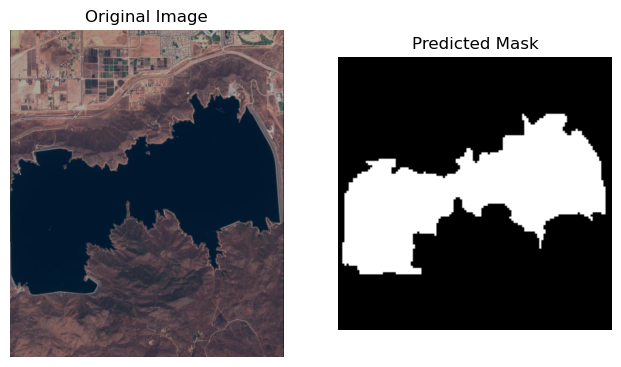

In [82]:
import matplotlib.pyplot as plt

original_image = load_img(new_image_path)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis("off")

true_mask_path = r"D:\Data_science\Data Science 3\Deep Learning\Water Bodies Dataset\Masks\water_body_12.jpg"
true_mask = load_img(true_mask_path, target_size=(img_height, img_width), color_mode="grayscale")

plt.subplot(1, 3, 3)
plt.title("True Mask")
plt.imshow(true_mask, cmap='gray')
plt.axis("off")

plt.show()
